In [ ]:
!pip install pycuda # install cuda

In [ ]:
!pip install pycuda # install cuda
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [ ]:
print("%d device(s) found." % cuda.Device.count())
 
dev = cuda.Device(0)
print("Device: %s", dev.name())
print("Compute Capability: %d.%d" % dev.compute_capability())
print("Total Memory: %s KB" % (dev.total_memory()//(1024)))
atts = [(str(att), value)
 for att, value in dev.get_attributes().items()]
atts.sort()
 
for att, value in atts:
 print(" %s: %s" % (att, value))

(4096, 4096)

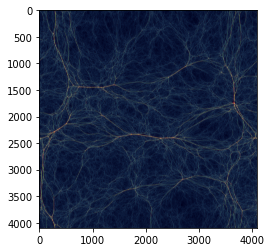

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy
 
img = Image.open("img.jpg")
plt.imshow(img)
img.size

In [ ]:
pix = numpy.array(img)
pix

R = pix[:, :, 0]
G = pix[:, :, 1]
B = pix[:, :, 2]

array([[[19, 23, 68],
        [20, 25, 63],
        [22, 29, 57],
        ...,
        [15, 24, 55],
        [18, 24, 56],
        [19, 25, 57]],

       [[20, 25, 65],
        [20, 26, 62],
        [22, 29, 58],
        ...,
        [15, 24, 55],
        [17, 23, 55],
        [18, 24, 56]],

       [[19, 27, 63],
        [20, 26, 60],
        [21, 28, 57],
        ...,
        [15, 24, 57],
        [15, 24, 55],
        [17, 23, 55]],

       ...,

       [[21, 33, 55],
        [20, 35, 58],
        [19, 40, 61],
        ...,
        [17, 26, 59],
        [18, 27, 60],
        [20, 28, 64]],

       [[22, 30, 53],
        [20, 32, 54],
        [19, 37, 57],
        ...,
        [18, 24, 60],
        [19, 25, 61],
        [20, 26, 62]],

       [[20, 28, 49],
        [19, 32, 51],
        [19, 37, 57],
        ...,
        [17, 23, 59],
        [18, 23, 61],
        [19, 24, 62]]], dtype=uint8)

In [ ]:
D = 4096
S = 4096

Rv = (D,S)
Gv = (D,S)
Bv = (D,S)

Rv = numpy.zeros(Rv)
Gv = numpy.zeros(Gv)
Bv = numpy.zeros(Bv)

R = R.astype(numpy.float32)
G = G.astype(numpy.float32)
B = B.astype(numpy.float32)

Rv = R.astype(numpy.float32)
Gv = G.astype(numpy.float32)
Bv = B.astype(numpy.float32)

Intencivity = (D,S)
Intencivity = numpy.zeros(Intencivity)
Intencivity = Intencivity.astype(numpy.float32)


In [ ]:
R_gpu = cuda.mem_alloc(R.nbytes)
G_gpu = cuda.mem_alloc(G.nbytes)
B_gpu = cuda.mem_alloc(B.nbytes)

D = numpy.int32(D)
S = numpy.int32(S)

Intencivity_gpu = cuda.mem_alloc(Intencivity.nbytes)

cuda.memcpy_htod(R_gpu,R)
cuda.memcpy_htod(G_gpu,G)
cuda.memcpy_htod(B_gpu,B)


In [ ]:
mod = SourceModule("""
  __global__ void calcIntenc(float *I, float *R, float *G, float *B, int n, int m)
  {
      int i;
      for(i = (blockIdx.y * blockDim.y + threadIdx.y) * blockDim.x * gridDim.x + (blockIdx.x * blockDim.x + threadIdx.x); 
      i < m*n; i += blockDim.y * gridDim.y * blockDim.x * gridDim.x) 
      {
          I[i] = (R[i]+G[i]+B[i])/3;
      }
  }
  """, options =['-use_fast_math'])

In [ ]:
calcIntenc = mod.get_function("calcIntenc")
calcIntenc(Intencivity_gpu, R_gpu, G_gpu, B_gpu, D, S, block=(32,32,1), grid=(1,1,1))

In [ ]:
cuda.memcpy_dtoh (Intencivity, Intencivity_gpu )

In [ ]:
Intencivity

array([[36.666668, 36.      , 36.      , ..., 31.333334, 32.666668,
        33.666668],
       [36.666668, 36.      , 36.333336, ..., 31.333334, 31.666668,
        32.666668],
       [36.333336, 35.333336, 35.333336, ..., 32.      , 31.333334,
        31.666668],
       ...,
       [36.333336, 37.666668, 40.      , ..., 34.      , 35.      ,
        37.333336],
       [35.      , 35.333336, 37.666668, ..., 34.      , 35.      ,
        36.      ],
       [32.333336, 34.      , 37.666668, ..., 33.      , 34.      ,
        35.      ]], dtype=float32)

In [ ]:
maxIntencivity = numpy.amax(Intencivity)      
maxIntencivity     

228.66667

In [ ]:
R

array([[19., 20., 22., ..., 15., 18., 19.],
       [20., 20., 22., ..., 15., 17., 18.],
       [19., 20., 21., ..., 15., 15., 17.],
       ...,
       [21., 20., 19., ..., 17., 18., 20.],
       [22., 20., 19., ..., 18., 19., 20.],
       [20., 19., 19., ..., 17., 18., 19.]], dtype=float32)

In [ ]:
G

array([[23., 25., 29., ..., 24., 24., 25.],
       [25., 26., 29., ..., 24., 23., 24.],
       [27., 26., 28., ..., 24., 24., 23.],
       ...,
       [33., 35., 40., ..., 26., 27., 28.],
       [30., 32., 37., ..., 24., 25., 26.],
       [28., 32., 37., ..., 23., 23., 24.]], dtype=float32)

In [ ]:
B

array([[68., 63., 57., ..., 55., 56., 57.],
       [65., 62., 58., ..., 55., 55., 56.],
       [63., 60., 57., ..., 57., 55., 55.],
       ...,
       [55., 58., 61., ..., 59., 60., 64.],
       [53., 54., 57., ..., 60., 61., 62.],
       [49., 51., 57., ..., 59., 61., 62.]], dtype=float32)

In [ ]:
cuda.memcpy_htod(Intencivity_gpu,Intencivity)
cuda.memcpy_htod(R_gpu,R)
cuda.memcpy_htod(G_gpu,G)
cuda.memcpy_htod(B_gpu,B)

In [ ]:
mod = SourceModule("""
  __global__ void filterIntenc(float *I, float *R, float *G, float *B, float max, int n, int m)
  {
      int i;
      for(i = (blockIdx.y * blockDim.y + threadIdx.y) * blockDim.x * gridDim.x + (blockIdx.x * blockDim.x + threadIdx.x); i < m*n; i += blockDim.y * gridDim.y * blockDim.x * gridDim.x) 
        {
          if(I[i] < max/10)
          {
            I[i] = 0;
            R[i] = 0;
            G[i] = 0;
            B[i] = 0;
          }
      }
  }
  """, options =['-use_fast_math'])

In [ ]:
filterIntenc = mod.get_function("filterIntenc")
filterIntenc(Intencivity_gpu, R_gpu, G_gpu, B_gpu, maxIntencivity, D, S, block=(1024,1,1), grid=(1,1,1))

In [ ]:
cuda.memcpy_dtoh (Intencivity, Intencivity_gpu )
cuda.memcpy_dtoh (R, R_gpu )
cuda.memcpy_dtoh (G, G_gpu )
cuda.memcpy_dtoh (B, B_gpu )

In [ ]:
Intencivity

array([[36.666668, 36.      , 36.      , ..., 31.333334, 32.666668,
        33.666668],
       [36.666668, 36.      , 36.333336, ..., 31.333334, 31.666668,
        32.666668],
       [36.333336, 35.333336, 35.333336, ..., 32.      , 31.333334,
        31.666668],
       ...,
       [36.333336, 37.666668, 40.      , ..., 34.      , 35.      ,
        37.333336],
       [35.      , 35.333336, 37.666668, ..., 34.      , 35.      ,
        36.      ],
       [32.333336, 34.      , 37.666668, ..., 33.      , 34.      ,
        35.      ]], dtype=float32)

In [ ]:
R

array([[19., 20., 22., ..., 15., 18., 19.],
       [20., 20., 22., ..., 15., 17., 18.],
       [19., 20., 21., ..., 15., 15., 17.],
       ...,
       [21., 20., 19., ..., 17., 18., 20.],
       [22., 20., 19., ..., 18., 19., 20.],
       [20., 19., 19., ..., 17., 18., 19.]], dtype=float32)

In [ ]:
G

array([[23., 25., 29., ..., 24., 24., 25.],
       [25., 26., 29., ..., 24., 23., 24.],
       [27., 26., 28., ..., 24., 24., 23.],
       ...,
       [33., 35., 40., ..., 26., 27., 28.],
       [30., 32., 37., ..., 24., 25., 26.],
       [28., 32., 37., ..., 23., 23., 24.]], dtype=float32)

In [ ]:
B

array([[68., 63., 57., ..., 55., 56., 57.],
       [65., 62., 58., ..., 55., 55., 56.],
       [63., 60., 57., ..., 57., 55., 55.],
       ...,
       [55., 58., 61., ..., 59., 60., 64.],
       [53., 54., 57., ..., 60., 61., 62.],
       [49., 51., 57., ..., 59., 61., 62.]], dtype=float32)

In [ ]:
Y = (D,S)
Y = numpy.zeros(Y)
Y = Y.astype(numpy.float32)
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
cuda.memcpy_htod(Intencivity_gpu,Intencivity)
cuda.memcpy_htod(R_gpu,R)
cuda.memcpy_htod(G_gpu,G)
cuda.memcpy_htod(B_gpu,B)

Rv_gpu = cuda.mem_alloc(Rv.nbytes)
Gv_gpu = cuda.mem_alloc(Gv.nbytes)
Bv_gpu = cuda.mem_alloc(Bv.nbytes)

Y_gpu = cuda.mem_alloc(Y.nbytes)

In [ ]:
mod = SourceModule("""
  __global__ void yellowChannel(float *I, float *R, float *G, float *B, float *Rv, float *Gv, float *Bv, float *Y, int n, int m)
  {
      int i;
      for(i = (blockIdx.y * blockDim.y + threadIdx.y) * blockDim.x * gridDim.x + (blockIdx.x * blockDim.x + threadIdx.x); 
      i < m*n; i += blockDim.y * gridDim.y * blockDim.x * gridDim.x) 
      {
          if(I[i] != 0)
          {
            float rg = R[i]-G[i];
            if (rg < 0)
            {
              rg = rg * (-1);
            }
            Rv[i] = R[i] - (G[i]+B[i])/2;
            Gv[i] = G[i] - (R[i]+B[i])/2;
            Bv[i] = B[i] - (G[i]+B[i])/2;
            Y[i] = R[i] + G[i] - 2*(rg+B[i]);
          }
      }
  }
  """, options =['-use_fast_math'])

In [ ]:
yellowChannel = mod.get_function("yellowChannel")
yellowChannel(Intencivity_gpu, R_gpu, G_gpu, B_gpu, Rv_gpu, Gv_gpu, Bv_gpu, Y_gpu, D, S, block=(1024,1,1), grid=(1,1,1))

In [ ]:
cuda.memcpy_dtoh (Y, Y_gpu )
cuda.memcpy_dtoh (Rv, Rv_gpu )
cuda.memcpy_dtoh (Gv, Gv_gpu )
cuda.memcpy_dtoh (Bv, Bv_gpu )

In [ ]:
Y

array([[-102.,  -91.,  -77., ...,  -89.,  -82.,  -82.],
       [ -95.,  -90.,  -79., ...,  -89.,  -82.,  -82.],
       [ -96.,  -86.,  -79., ...,  -93.,  -89.,  -82.],
       ...,
       [ -80.,  -91., -105., ...,  -93.,  -93.,  -96.],
       [ -70.,  -80.,  -94., ...,  -90.,  -90.,  -90.],
       [ -66.,  -77.,  -94., ...,  -90.,  -91.,  -91.]], dtype=float32)

In [ ]:
Rv

array([[-26.5, -24. , -21. , ..., -24.5, -22. , -22. ],
       [-25. , -24. , -21.5, ..., -24.5, -22. , -22. ],
       [-26. , -23. , -21.5, ..., -25.5, -24.5, -22. ],
       ...,
       [-23. , -26.5, -31.5, ..., -25.5, -25.5, -26. ],
       [-19.5, -23. , -28. , ..., -24. , -24. , -24. ],
       [-18.5, -22.5, -28. , ..., -24. , -24. , -24. ]], dtype=float32)

In [ ]:
Gv

array([[-20.5, -16.5, -10.5, ..., -11. , -13. , -13. ],
       [-17.5, -15. , -11. , ..., -11. , -13. , -13. ],
       [-14. , -14. , -11. , ..., -12. , -11. , -13. ],
       ...,
       [ -5. ,  -4. ,   0. , ..., -12. , -12. , -14. ],
       [ -7.5,  -5. ,  -1. , ..., -15. , -15. , -15. ],
       [ -6.5,  -3. ,  -1. , ..., -15. , -16.5, -16.5]], dtype=float32)

In [ ]:
Bv

array([[22.5, 19. , 14. , ..., 15.5, 16. , 16. ],
       [20. , 18. , 14.5, ..., 15.5, 16. , 16. ],
       [18. , 17. , 14.5, ..., 16.5, 15.5, 16. ],
       ...,
       [11. , 11.5, 10.5, ..., 16.5, 16.5, 18. ],
       [11.5, 11. , 10. , ..., 18. , 18. , 18. ],
       [10.5,  9.5, 10. , ..., 18. , 19. , 19. ]], dtype=float32)

In [ ]:
newImg = numpy.dstack((Rv, Gv, Bv))
newImg

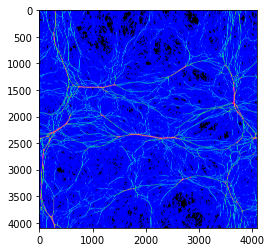

In [ ]:
plt.imshow(newImg)
